In [513]:
import random
import numpy as np
import cec2017.functions as functions
import copy

In [514]:
Dim = 10
NP = 10
bound = 100

In [515]:
X = np.random.uniform(low=-bound, high=bound, size=Dim)
X_min = X.min()
X_max = X.max()
X_list = np.empty([NP, Dim])
for i in range(NP):
    for j in range(Dim):
        X_list[i][j] = X_min + random.uniform(0, 1) * (X_max - X_min)

X_list

array([[ 14.33232114,  52.42326091,  67.06493425, -58.05432958,
         48.25095476,  47.42738198,  17.10547032, -25.36542291,
         26.99608334,  77.55791052],
       [ 75.44317567,  82.38363883,  89.67551675,   4.45157582,
         48.49108278, -12.13293725,  52.60102884, -36.12918332,
         86.38694679,  49.03789223],
       [-55.69488968, -27.54502889,  34.19024557, -16.97559251,
        -39.68604417,  29.92020242, -19.56418612,  27.77926646,
        -11.74369308, -33.18624663],
       [ 60.66216044,  94.51979036,   2.48544621, -35.72432257,
         38.07457345,  34.98200702,  52.93959089, -53.42089317,
         88.90468558,  30.1363695 ],
       [ -1.91419499,  97.61182025,  79.58553478,   1.26486538,
        -24.14291273,  62.06264722,  44.52279373, -39.08578039,
         60.79771983, -32.42001128],
       [ 33.24744838,  48.54292158,  61.68093441,  32.79823645,
        -16.90689526, -17.37277117,  27.9679915 , -22.52316435,
         60.3519069 ,  85.21661148],
       [-4

In [516]:
""":parameter for DE"""
T_DE = 100
no = 5
CR = 0.9  # rate of crossover

""":parameter for MMS"""
mms_e = 0.000001
mms_F = 0.5

In [517]:
""":parameter k and F: for current/rand/1"""
k = 0.3
F = 0.5

In [518]:
""":parameter for crossoverSBX"""
sbx_n = 10

In [519]:
# f = functions.f1

In [520]:
def feas(x):
    if x.max() <= bound and x.min() >= -bound:
        return 1
    else:
        return 0

In [521]:
def select_better_fit(x1, x2, f):
    if f(x1) <= f(x2):
        return x1
    else:
        return x2

In [522]:
def current_to_rand(x_list, r1, r2, r3, i):
    return np.add(x_list[i], k * np.subtract(x_list[r1], x_list[i]), F * np.subtract(x_list[r2], x_list[r3]))

In [523]:
def immsade(xx_list, r1, r2, r3):
    immsade_omega = random.uniform(0.7, 1.0)
    immsade_F = random.uniform(0.5, 0.8)
    v_delta = np.add(np.multiply(immsade_omega, xx_list[r1]),
                     immsade_F * np.subtract(xx_list[r2], xx_list[r3]))
    v_delta = np.maximum(v_delta, -100)
    v_delta = np.minimum(v_delta, 100)
    return v_delta

In [524]:
def crossover_SBX(x_i, v_j, f):
    beta = 0
    while isinstance(beta, complex):
        sbx_rand = random.random()
        if sbx_rand <= 0.5:
            beta = (2 * sbx_rand) ** (1 / (1 + sbx_n))
        else:
            beta = (1 / (2 - sbx_n * 2)) ** (1 / (1 + sbx_n))

    c1 = 0.5 * np.add((1 + beta) * x_i, (1 - beta) * v_j)  # crossover
    c2 = 0.5 * np.add((1 - beta) * x_i, (1 + beta) * v_j)
    return select_better_fit(c1, c2, f)

In [525]:
def DE(f):
    x_list = copy.deepcopy(X_list)
    x_best = x_list[0]
    # print(x_list[0])

    t = 1
    while t <= T_DE:
        for i in range(NP):
            u_best = np.empty([Dim])
            for j in range(Dim):
                r_list = random.sample(range(NP), 5)
                for m in range(no):
                    while r_list[m] == i:
                        r_list[m] = random.randint(0, Dim - 1)

                v_j = np.empty([Dim])
                v_j = immsade(x_list, r_list[1], r_list[2], r_list[3])

                cr_rand = random.random()
                if cr_rand <= CR:
                    u_j = crossover_SBX(x_list[i], v_j, f)
                else:
                    u_j = x_list[i]

                if j == 0:
                    u_best = u_j
                else:
                    u_best = select_better_fit(u_best, u_j, f)

                if f(u_best) <= f(x_list[i]) and feas(u_best) == 1:
                    x_list[i] = u_best

                if f(x_list[i]) < f(x_best) and feas(x_list[i]) == 1:
                    x_best = x_list[i]

        t += 1
    return x_best


In [526]:
""":parameter: for AGDE"""
T_AGDE = 100

In [527]:
def index_of_X_best(xx_list, f):
    index = 0
    min_fit = f(xx_list[0])
    for i in range(len(xx_list)):
        if f(xx_list[i]) < min_fit:
            index = i
            min_fit = f(xx_list[i])
    return index


def index_of_X_worst(xx_list, f):
    index = 0
    max_fit = f(xx_list[0])
    for i in range(len(xx_list)):
        if f(xx_list[i]) > max_fit:
            index = i
            max_fit = f(xx_list[i])
    return index


def compare_max(delta):
    """
    lower bound
    :param delta: delta
    :return: turn into lower bound delta
    """

    em = np.linspace(-100, -100, Dim)
    delta = np.maximum(delta, em)
    return delta


def compare_min(delta):
    on = np.linspace(100, 100, Dim)
    delta = np.minimum(delta, on)
    # for i in range(len(delta)):
    #     delta[i] = min(delta[i], 1)
    return delta

def agde(xx_list, agde_F, agde_p, f):
    agde_NP = max(int(NP * agde_p), 0)
    r_list = random.randint(max(agde_NP * 2 - 1, 0), NP - 1)
    if max(agde_NP, 0) >= max(agde_NP * 2 - 1, 1):
        m = max(agde_NP, 0) + 1
    else:
        m = max(agde_NP * 2 - 1, 1)
    x_p_worst = xx_list[index_of_X_worst(xx_list[max(agde_NP, 0): m], f)]
    x_p_best = xx_list[index_of_X_best(xx_list[: max(agde_NP - 1, 1)], f)]
    v_delta = np.add(xx_list[r_list], np.multiply(agde_F, np.subtract(x_p_best, x_p_worst)))
    return v_delta

In [528]:
def AGDE(f):
    xx_list = copy.deepcopy(X_list)
    x_best = xx_list[0]
    # print(xx_list[0])

    G = 0
    p_j = 0.5
    s_j_sum = 0
    while G <= T_AGDE:  # iteration of DE
        n_s_j = 0
        f_j = 1
        for i in range(NP):  # iteration of generation
            agde_F = random.uniform(0.1, 1)
            Cr = 0
            if G == 1:
                if random.uniform(0, 1) <= 0.5:
                    Cr = random.uniform(0.05, 0.15)
                else:
                    Cr = random.uniform(0.9, 1)
            else:
                if random.uniform(0, 1) <= p_j:
                    Cr = random.uniform(0.05, 0.15)
                else:
                    Cr = random.uniform(0.9, 1)
            j_random = random.randint(1, NP)

            u_best = np.empty([Dim])
            for j in range(Dim):
                vj = agde(xx_list, agde_F, p_j, f)
                vj = compare_max(vj)
                vj = compare_min(vj)
                if random.uniform(0, 1) < Cr or j == j_random:
                    u_j = crossover_SBX(xx_list[i], vj, f)
                else:
                    u_j = xx_list[i]

                if j == 0:
                    u_best = u_j
                else:
                    u_best = select_better_fit(u_best, u_j, f)

                if f(u_best) <= f(xx_list[i]) and feas(u_best) == 1:
                    xx_list[i] = u_best

                if f(xx_list[i]) < f(x_best) and feas(xx_list[i]) == 1:
                    x_best = xx_list[i]

        G += 1

        s_j = n_s_j / (n_s_j + f_j) + 0.01
        s_j_sum += s_j
        p_s_j = s_j / s_j_sum
        if (((G - 1) * p_j + p_s_j) / G) < 0.5:
            p_j = ((G - 1) * p_j + p_s_j) / G

    return x_best

In [529]:
""":parameter: for GSK"""
T_GSK = 100
GSK_p = 0.1
k_f = 0.01   # 0.5
k_r = 0.1   # 0.9
K = 10

In [530]:
def junior(xx_list, r, i, f):
    if random.uniform(0, 1) <= k_r:
        if f(xx_list[i]) > f(xx_list[r]):
            v_delta = np.add(xx_list[i],
                             k_f * np.add(np.subtract(xx_list[max(0, i - 1)], xx_list[min(NP - 1, i + 1)]),
                                          np.subtract(xx_list[r], xx_list[i])))
        else:
            v_delta = np.add(xx_list[i],
                             k_f * np.add(np.subtract(xx_list[max(0, i - 1)], xx_list[min(NP - 1, i + 1)]),
                                          np.subtract(xx_list[i], xx_list[r])))
    else:
        v_delta = xx_list[i]
    return v_delta


def senior(xx_list, i, D_junior, f):
    if random.uniform(0, 1) <= k_r:
        D_senior = NP - D_junior
        NP_1 = int(D_senior * GSK_p)
        r_list = random.randint(D_junior - 1 + NP_1 * 2, NP - 1)
        if max(D_junior - 1 + NP_1, 0) >= max(D_junior - 1 + NP_1 * 2 - 1, 1):
            m = max(D_junior - 1 + NP_1, 0) + 1
        else:
            m = max(D_junior - 1 + NP_1 * 2 - 1, 1)
        if max(D_junior - 1, 0) >= max(D_junior - 1 + NP_1 - 1, 1):
            n = max(D_junior - 1, 0) + 1
        else:
            n = max(D_junior - 1 + NP_1 - 1, 1)
        x_p_worst = xx_list[index_of_X_worst(xx_list[max(D_junior - 1 + NP_1, 0): m], f)]
        x_p_best = xx_list[index_of_X_best(xx_list[max(D_junior - 1, 0): n], f)]
        if f(xx_list[i]) > f(xx_list[r_list]):
            v_delta = np.add(xx_list[i],
                             k_f * np.add(np.subtract(x_p_best, x_p_worst),
                                          np.subtract(xx_list[r_list], xx_list[i])))
        else:
            v_delta = np.add(xx_list[i],
                             k_f * np.add(np.subtract(x_p_best, x_p_worst),
                                          np.subtract(xx_list[i], xx_list[r_list])))
    else:
        v_delta = xx_list[i]
    return v_delta

In [531]:
def GSK(f):
    """
    DE algorithm
    :param x_list:
    :return: best x by DE
    """
    xxx_list = copy.deepcopy(X_list)

    x_best = xxx_list[0]
    # print(xxx_list[0])
    G = 0

    while G <= T_GSK:  # iteration of DE
        D_junior = int(NP * pow((1 - G / T_GSK), K))

        for i in range(NP):  # iteration of generation

            u_best = np.empty([Dim])
            for j in range(Dim):
                vj = np.empty([Dim])
                r = random.randint(0, NP - 1)
                if j <= D_junior:
                    vj = junior(xxx_list, r, j, f)
                else:
                    vj = senior(xxx_list, j, D_junior, f)

                vj = compare_max(vj)
                vj = compare_min(vj)

                if j == 0:
                    u_best = vj
                else:
                    u_best = select_better_fit(u_best, vj, f)

                if f(u_best) <= f(xxx_list[i]) and feas(u_best) == 1:
                    xxx_list[i] = u_best

                if f(xxx_list[i]) < f(x_best) and feas(xxx_list[i]) == 1:
                    x_best = xxx_list[i]

        G += 1

    return x_best


In [532]:
import os
test_list = np.empty([len(functions.all_functions), 3])
test_path = r'D:\profile\codes\python_projects\ocp\test\output\D10_cpu'
for i in range(1, 52):
    j = 0
    for f in functions.all_functions:
        x_best_DE_fit = 0
        x_best_AGDE_fit = 0
        x_best_GSK_fit = 0
        x_best_DE_fit = f(DE(f))
        x_best_AGDE_fit = f(AGDE(f))
        x_best_GSK_fit = f(GSK(f))
        print(f.__name__, x_best_DE_fit, x_best_AGDE_fit, x_best_GSK_fit, "\n")
        test_list[j][0] = x_best_DE_fit
        test_list[j][1] = x_best_AGDE_fit
        test_list[j][2] = x_best_GSK_fit
        j += 1

    np.savetxt(os.path.join(test_path, str(i) + ".txt"), test_list)




f1 189102974358.9143 244450107409.0629 250741725128.88977 

f2 253238825420.92413 4870522706052.807 8.511416985192576e+18 

f3 16009.008074728568 24900.543349739044 39459.0326992788 

f4 2538.022004411552 3928.3719772853906 4341.378807362841 

f5 627.561135662678 667.7219180262789 723.8102940686368 

f6 663.6163538487275 696.3854641209989 741.0949766830574 

f7 832.5502455028723 1036.670472079257 1133.0220909127274 

f8 857.8938396468707 911.3130451903876 966.9787546319225 

f9 1639.9842653788824 2211.5025108678997 6017.956585983571 

f10 2594.8844131362657 3464.132672980209 3748.645867467526 

f11 7846.2872124715705 12917.888152821663 15538.289727942072 

f12 1145276026.134582 2016912738.09937 3243322194.675908 

f13 1547196.6932273176 178876294.74823555 3592202548.956926 

f14 3307.112461420179 1899.1533324969732 1314788.1189674274 

f15 7882.788210042754 16784.63052388413 14287903428.391151 

f16 2329.1299849962156 2406.8575833791188 3271.8707047006865 



c:\users\chris\appdata\local\programs\python\python39\lib\site-packages\cec2017\basic.py:227: RuntimeWarning: invalid value encountered in true_divide
  t = np.abs(tjx - np.round(tjx)) / tj


f17 nan nan nan 

f18 3749867590.7375927 8028238445.953784 8502210689.650127 

f19 538335644.8810253 9545102136.401796 11609390035.48189 

f20 nan nan nan 

f21 2452.746485672975 2455.027101774531 2511.4695760172494 

f22 2658.1573748365754 3294.1626108612427 3421.326075060282 

f23 2991.0090927018196 2978.3024930336746 3583.550660536082 

f24 2939.269373660741 3416.1085776462205 3662.5741329106204 

f25 3679.3318827736366 4892.095961785141 4898.75631086405 

f26 4560.362323316634 4913.206309926152 5445.2769322503245 

f27 3327.356564369909 4645.890699526875 4612.720995637437 

f28 3848.7232444897 4004.9907368021804 4463.128265121683 

f29 nan nan nan 

f30 27389614.768751226 135390185.12349954 236609905.42279345 

f1 200619713314.36102 241833487987.88556 250741725128.88977 

f2 2354695614.7563972 2588082145047.0615 8.528777230193226e+18 

f3 14510.887025914499 30678.43639613812 85801.85920343937 

f4 1565.8640213007588 3663.607473248046 4395.15056610481 

f5 657.739589951899 690.50396

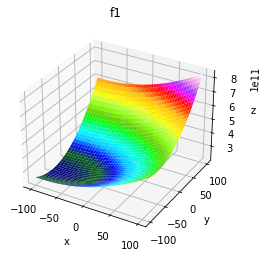

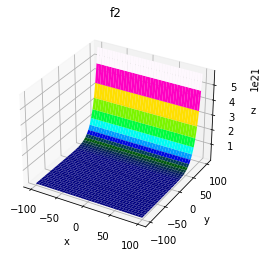

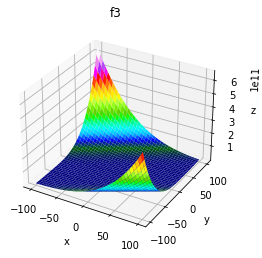

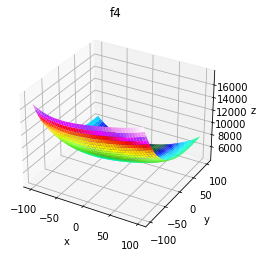

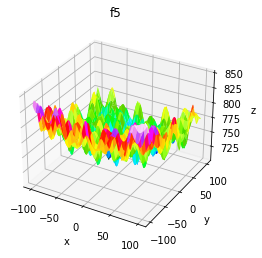

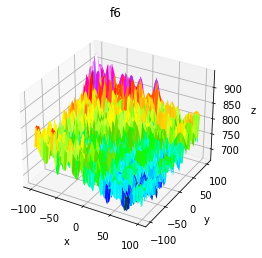

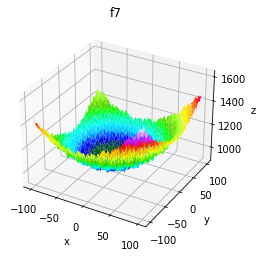

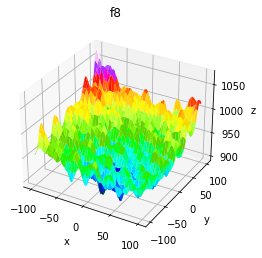

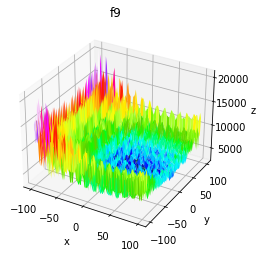

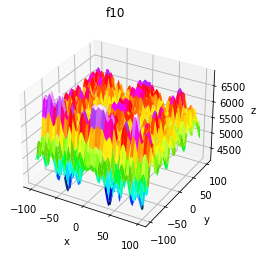

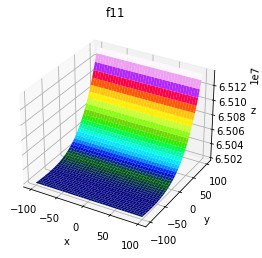

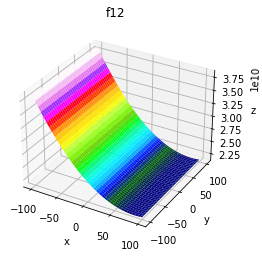

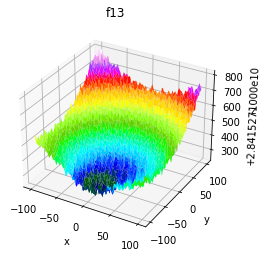

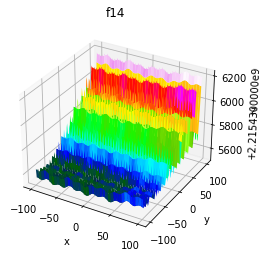

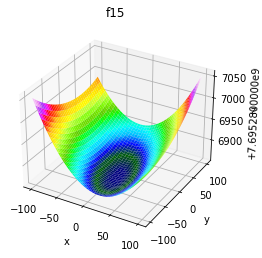

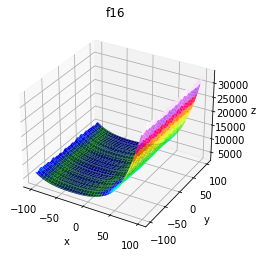

c:\users\chris\appdata\local\programs\python\python39\lib\site-packages\cec2017\utils.py:46: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  ax.plot_surface(X, Y, Z, cmap='gist_ncar', edgecolor='none')


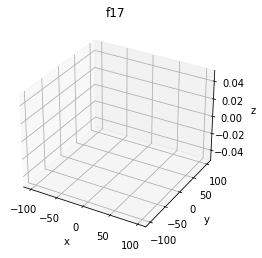

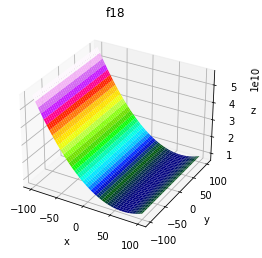

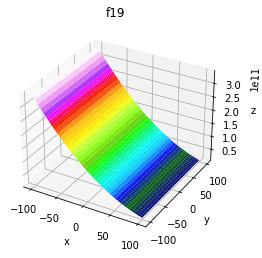

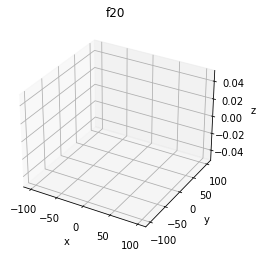

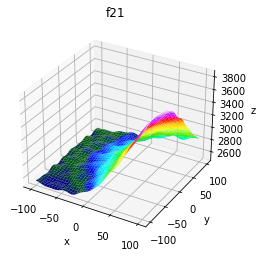

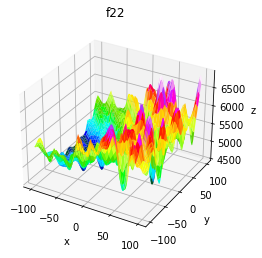

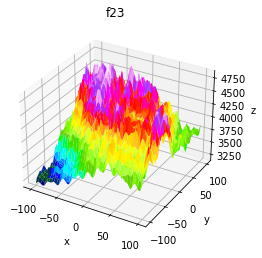

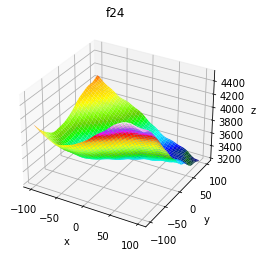

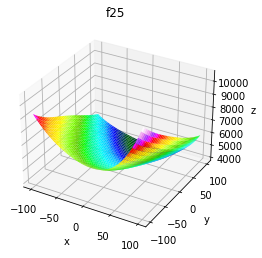

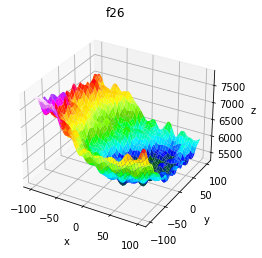

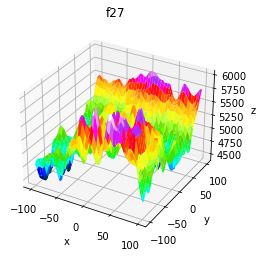

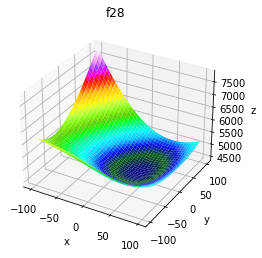

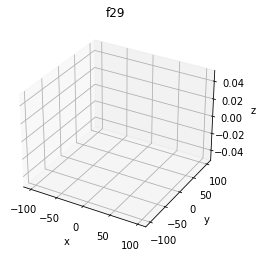

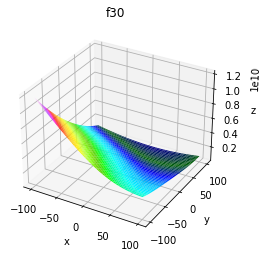

In [533]:
import cec2017.utils as utils
for f in functions.all_functions:
    utils.surface_plot(f, points=120, dimension=Dim)